In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/Colab/Internship/Multi_View_Cars'
! ls 

/content/gdrive/My Drive/Colab/Internship/Multi_View_Cars
'Bản sao của ResNet152_TL.ipynb'   front_car.jpg	  ResNet152_TL.ipynb
 car.jpg			   Inceptionv3_TL.ipynb   right_side.png
 Data_final.zip			   MultiCar_final.model   Untitled0.ipynb
 Final_ResNet152_TL.ipynb	   MultiCar.model
 front_car2.jpg			   Preprocessed_Data


In [ ]:
local_zip = 'Data_final.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/Data_final'
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')


# **ImageDataGenerator (in-place augmentation)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_data_gen = ImageDataGenerator(
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=[0.3, 1],
                                    #horizontal_flip=True,
                                    shear_range = 0.2,
                                    #vertical_flip=True,
                                    fill_mode='nearest',
                                    #cval=0,
                                    rescale=1./255)



valid_data_gen = ImageDataGenerator(rescale=1./255)

#test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
dataset_dir = '/tmp/Data_final'

Batch_size = 8
img_h = 256
img_w = 256
num_classes=4

classes = ['front', # 0
            'rear', #1
           'left_side', #2
           'right_side' #3
           ]

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Training
SEED = 1234
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'Training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_dir = os.path.join(dataset_dir, 'Validation')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
# Test
# test_dir = os.path.join(dataset_dir, 'testing')
# test_gen = test_data_gen.flow_from_directory(test_dir,
#                                              target_size=(256, 256),
#                                              batch_size=10, 
#                                              shuffle=False,
#                                              seed=SEED,
#                                              class_mode=None,
#                                              )
class_weights_list = class_weight.compute_class_weight('balanced',
                                                   np.unique(train_gen.classes),
                                                   train_gen.classes )

print('class_weight: {}'.format(class_weights_list) )

Found 1460 images belonging to 4 classes.
Found 366 images belonging to 4 classes.
class_weight: [1.58695652 1.55319149 0.71289062 0.75569358]


In [ ]:
class_weights = {}
for i in range(4):
  class_weights[i] =  class_weights_list[i]



In [ ]:
print(valid_gen.class_indices)
print(train_gen.class_indices)
print(class_weights)

{'front': 0, 'rear': 1, 'left_side': 2, 'right_side': 3}
{'front': 0, 'rear': 1, 'left_side': 2, 'right_side': 3}
{0: 1.5869565217391304, 1: 1.553191489361702, 2: 0.712890625, 3: 0.7556935817805382}



# **Visualization data**

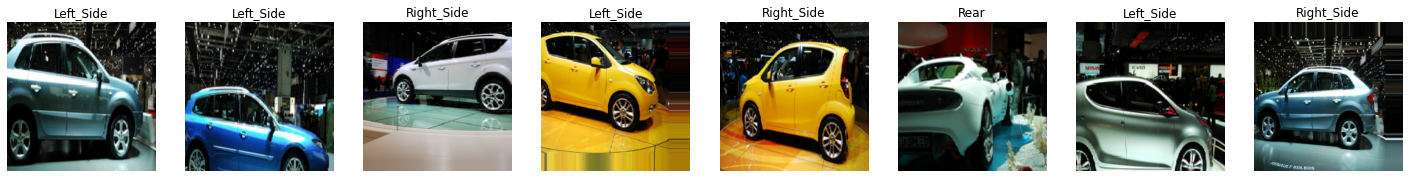

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

CLASS_NAMES = np.array(['front', 'rear', 'left_side', 'right_side'], dtype='<U10')



def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

# ***ResNet152V2 Model***

In [ ]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

234553344/234545216 [==============================] - 9s 0us/step


In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size


transfer_learning_history = model.fit_generator(generator=train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=30,
                  callbacks=callbacks,
                  class_weight=class_weights
                                
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
182/182 [==============================] - 54s 296ms/step - loss: 0.8141 - accuracy: 0.6088 - val_loss: 1.7042 - val_accuracy: 0.5528
Epoch 2/30
182/182 [==============================] - 50s 275ms/step - loss: 0.5231 - accuracy: 0.7638 - val_loss: 0.3488 - val_accuracy: 0.9139
Epoch 3/30
182/182 [==============================] - 50s 275ms/step - loss: 0.3793 - accuracy: 0.8450 - val_loss: 0.2097 - val_accuracy: 0.9333
Epoch 4/30
182/182 [==============================] - 50s 275ms/step - loss: 0.3216 - accuracy: 0.8809 - val_loss: 0.3074 - val_accuracy: 0.9083
Epoch 5/30
182/182 [==============================] - 50s 275ms/step - loss: 0.2390 - accuracy: 0.8988 - val_loss: 0.1679 - val_accuracy: 0.9417
Epoch 6/30
182/182 [==============================] - 50s 275ms/step - loss: 0.2776 - accuracy: 0.8919 - val_loss: 0.2055 - val_accuracy: 0.9417
Epoch 7/30
182/182 [==============================] - 

In [ ]:
#model.save('MultiCar_final.model')
model.save('MultiCar_final.h5')

# **Visualization accuracy and loss**

Text(0.5, 1.0, 'Training and Validation Loss')

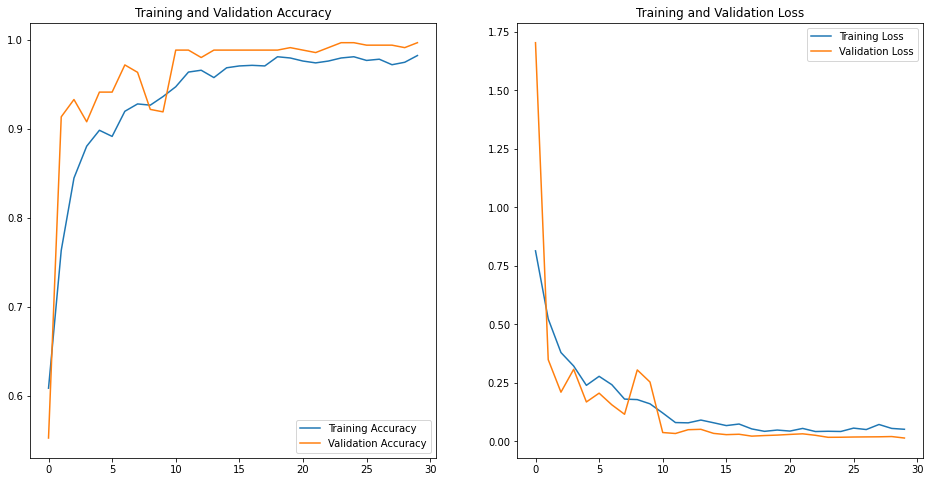

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred=model.predict_generator(valid_gen, steps = 366//8+1 )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))
print('Classification Report')
print(classification_report(valid_gen.classes, y_pred))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[ 57   1   0   0]
 [  0  59   0   0]
 [  0   0 128   0]
 [  0   0   0 121]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        59
           2       1.00      1.00      1.00       128
           3       1.00      1.00      1.00       121

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



In [ ]:
# from tensorflow import keras
# print(os.listdir())
# model = keras.models.load_model('MultiCar_final.model')
